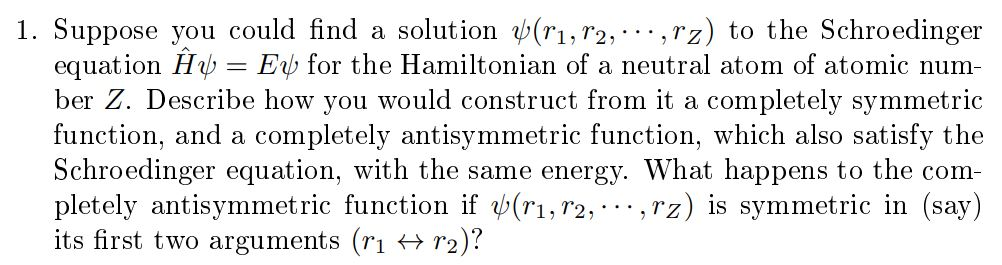

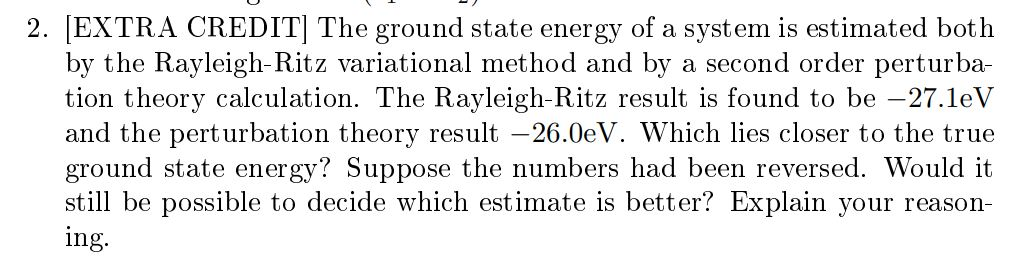

In [1]:
from IPython.display import Image
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.collections import LineCollection
#from scipy.special import hermite, factorial, eval_hermite
from matplotlib.animation import FuncAnimation
import os
import glob
import shutil
import matplotlib.style as style
import pandas as pd
from scipy.integrate import quad
from scipy.linalg import eigh
import ipywidgets as widgets
from ipywidgets import interact

style.use('dark_background')
plt.rcParams['text.usetex'] = False



#display screenshots
for i in range(1, 3):
    display(Image(filename=f'p_statement/p{i}.jpg'))

#file moving for housekeeping
def move_plots():
    output_dir = 'graphs'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    #all gif and png
    files_to_move = glob.glob('*.png') + glob.glob('*.gif')

    for file in files_to_move:
        destination = os.path.join(output_dir, file)

        #if exists, replace
        if os.path.exists(destination):
            os.remove(destination)

        #move it
        shutil.move(file, destination)
        print(f'Moved {file} to {output_dir}')

Eq(psi_s, sqrt(2)*(phi1(x1)*phi2(x2) + phi1(x2)*phi2(x1))/2)

Eq(psi_a, sqrt(2)*(phi1(x1)*phi2(x2) - phi1(x2)*phi2(x1))/2)

Eq(psi_a_same, 0)

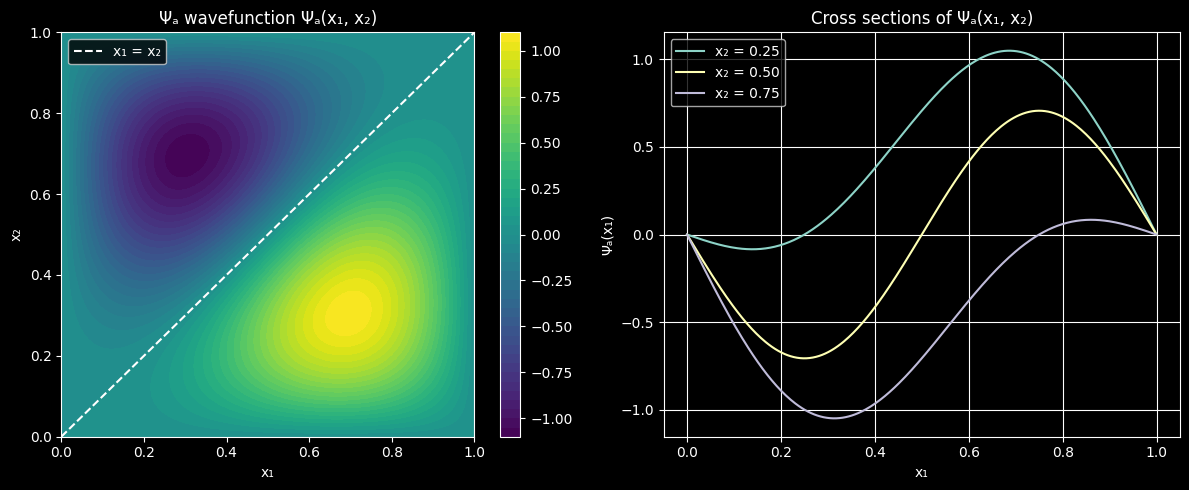

In [2]:
def problem_1():
    #when i use two particle wavefunc.
    x1, x2 = sp.symbols('x1 x2')
    phi1 = sp.Function('phi1')
    phi2 = sp.Function('phi2')

    #og product state (not symmetry)
    psi = phi1(x1)*phi2(x2)

    #symmetric combo
    psi_s = (phi1(x1)*phi2(x2) + phi1(x2)*phi2(x1))/sp.sqrt(2)

    #antisymmetric combo
    psi_a = (phi1(x1)*phi2(x2) - phi1(x2)*phi2(x1))/sp.sqrt(2)

    #display symbolic results
    display(sp.Eq(sp.Symbol('psi_s'), psi_s))
    display(sp.Eq(sp.Symbol('psi_a'), psi_a))

    #i can test antisymmetry when phi1 == phi2
    psi_a_same = psi_a.subs(phi2(x2), phi1(x2)).subs(phi2(x1), phi1(x1))

    #should simplify to zero
    display(sp.Eq(sp.Symbol('psi_a_same'), sp.simplify(psi_a_same)))

    #it does therefore psi_a vanishes if orbitals are same
    #just a quick visual when psi1 not equal to phi2
    def phi1_fn(x):
        return np.sin(np.pi * x)  #ex 1s

    def phi2_fn(x):
        return np.sin(2 * np.pi * x)  #ex 2s

    x = np.linspace(0, 1, 300)
    X1, X2 = np.meshgrid(x, x)
    psi_a_vals = (phi1_fn(X1) * phi2_fn(X2) - phi1_fn(X2) * phi2_fn(X1)) / np.sqrt(2)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    #make subplot here, left will be contour
    cs = ax1.contourf(X1, X2, psi_a_vals, levels=50)
    fig.colorbar(cs, ax=ax1)
    ax1.set_title('Ψₐ wavefunction Ψₐ(x₁, x₂)')
    ax1.set_xlabel('x₁')
    ax1.plot(x, x, 'w--', label='x₁ = x₂')
    ax1.legend()
    ax1.set_ylabel('x₂')

    #right will now be cross section
    for x2_fixed in [0.25, 0.5, 0.75]:
        psi_cross = (phi1_fn(x) * phi2_fn(x2_fixed) - phi1_fn(x2_fixed) * phi2_fn(x)) / np.sqrt(2)
        ax2.plot(x, psi_cross, label=f'x₂ = {x2_fixed:.2f}')

    ax2.set_title('Cross sections of Ψₐ(x₁, x₂)')
    ax2.set_xlabel('x₁')
    ax2.set_ylabel('Ψₐ(x₁)')
    ax2.legend()
    ax2.grid()

    plt.tight_layout()
    plt.savefig('problem_1.png', dpi=600)
    plt.show()


problem_1()


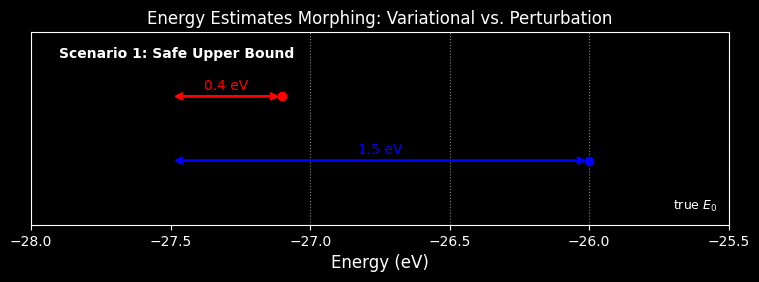

In [3]:
#i wanna show the 'safe' regions that i state in math
#will try 'number line style'
#TODO: turn to gif if have time


#config
frames = 60  #param, total frames per
E0 = -27.5 #arbitrary but needed hard num
E_var_1, E_pert_1 = -27.1, -26.0 #scenario 1
E_var_2, E_pert_2 = -26.0, -27.1 #scenario 2

#fig ax call
fig, ax = plt.subplots(figsize=(9, 2.5))
ax.set_xlim(-28, -25.5)
ax.set_ylim(0, 1.5)
ax.set_yticks([])
ax.set_xlabel('Energy (eV)', fontsize=12)
ax.set_title('Energy Estimates Morphing: Variational vs. Perturbation')
ax.grid(axis='x', linestyle=':', alpha=0.5)

#draw true static line for true energy E0
ax.axvline(E0, color='black', linewidth=2, label='true $E_0$')

#get this in for dynamic element, recalculate upon loop
dot_var, = ax.plot([], [], 'ro')
dot_pert, = ax.plot([], [], 'bo')
arrow_var = ax.annotate('', xy=(0, 0), xytext=(0, 0),
                        arrowprops=dict(arrowstyle='<->', color='red', lw=2))
arrow_pert = ax.annotate('', xy=(0, 0), xytext=(0, 0),
                         arrowprops=dict(arrowstyle='<->', color='blue', lw=2))
text_var = ax.text(0, 0, '', ha='center', color='red')
text_pert = ax.text(0, 0, '', ha='center', color='blue')
morph_label = ax.text(-27.9, 1.3, '', fontsize=10, weight='bold')

ax.legend(loc='lower right', fontsize=9, frameon=False)

#interpotlate this based on time
def interp(start, end, t):
    return (1 - t) * start + t * end

def update(frame):
    #bounce, forward 0 frame, backwards 2*count frame set abvoe
    if frame < frames:
        t = frame / (frames - 1)
    else:
        t = 1 - (frame - frames) / (frames - 1)

    #call interpolate funct
    E_var = interp(E_var_1, E_var_2, t)
    E_pert = interp(E_pert_1, E_pert_2, t)
    err_var = abs(E_var - E0)
    err_pert = abs(E_pert - E0)

    #update, wrap in list
    dot_var.set_data([E_var], [1])
    dot_pert.set_data([E_pert], [0.5])
    arrow_var.set_position((E_var, 1))
    arrow_var.xy = (E0, 1)
    arrow_pert.set_position((E_pert, 0.5))
    arrow_pert.xy = (E0, 0.5)
    text_var.set_position(((E_var + E0)/2, 1.05))
    text_pert.set_position(((E_pert + E0)/2, 0.55))
    text_var.set_text(f'{err_var:.1f} eV')
    text_pert.set_text(f'{err_pert:.1f} eV')

    #morph condition and label morph label
    if t < 0.5:
        morph_label.set_text('Scenario 1: Safe Upper Bound')
    else:
        morph_label.set_text('Scenario 2: Perturbation Possibly Overshoots')

    return dot_var, dot_pert, arrow_var, arrow_pert, text_var, text_pert, morph_label

#call ani and save
ani = animation.FuncAnimation(fig, update, frames=2*frames, interval=60, blit=False)
ani.save('problem_2_ani.gif', writer='pillow')


In [4]:
move_plots()

Moved problem_1.png to graphs
Moved problem_2_ani.gif to graphs
